# Support Vector Machine Model on Spotify Features

## Introduction

In this notebook, we will use the pre-extracted features from Spotify to train our model. We will try to predict the genre using just these features as the Spotify algorithm uses them to recommend music to listeners. We are going to use 10 genres and approximately 400 songs per genre in order to train the model.

The first step is importing the libraries required for this endeavour.

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

## Loading the Dataset

We have already pinged the Spotify API to download the relevant songs from the artists and created a csv file called `subsampled` which we will load here. We will also look at the counts of the relevant genres to see if further balancing is required.



In [7]:
music = pd.read_csv("subsampled.csv")
music['Genre'].value_counts()

Classical    505
Rock         359
Pop          313
Hip-Hop      243
Blues        216
Rap          210
Qawwali      186
Ghazal       145
EDM          139
Metal         99
Name: Genre, dtype: int64

## Balancing the dataset through stratification

Unfortunately, there aren't enough files for EDM, Ghazal, Metal and Qawwali. Since some tracks did not have a Preview URL because of location and other restrictions, they could not be downloaded and their features could not be extracted. Thus, they were excluded from the dataset.Thus, the sample set of these genres has been reduced dramatically. In order to overcome this limitation, we will use stratification i.e. we will stratify by class as the future dataset on which this prediction will be made has the same distribution

In [8]:
X = music.iloc[:,7:-1].values

## Extracting Genres
y = music['Genre']

# split into training data (80%) and test data (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify = y, shuffle = True, random_state=0)

Now that we've stratified and split the dataset, we can get to training the model. In the first step, we will train the model without any hyperparameter tuning using the default parameters for `SVC` i.e. `Kernel` = `RBF` and `C` = 1. Then, we will test the accuracy to see if this model, without any tuning is good at predicting the genres based on Spotify's features

In [10]:
# Standardize
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

#create parameter grid for tuning
svm = SVC(kernel = 'rbf', C=1, random_state = 0)
svm.fit(X_train_standardized,y_train)
y_predicted = svm.predict(X_test_standardized)
## 
print("Accuracy :\n", accuracy_score(y_true=y_test, y_pred=y_predicted))

Accuracy :
 0.5


The accuracy of the model is only 48%. It seems that there are some limitations with using just spotify features to predict a track's genre. We will now try hyperparameter tuning to see if the accuracy is improved in any way. In order to do so, we will consider multiple values for `C`, `gamma` and will also let the tuning determine the `kernel` to be used in the final model. After the tuning is done, we will use the best parameters to estimate the result once again.

In [7]:
param_grid = { 'C':[0.1,1,100],'kernel': ['rbf','sigmoid','linear','poly'], 'degree': [1,2,3], 'gamma': [1, 0.1, 0.01]}
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, n_jobs= -1)

# train SVM
grid_model_result = grid.fit(X_train_standardized, y_train)

#extracting best parameters
best_params = grid.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [9]:
best_params

{'C': 100, 'degree': 1, 'gamma': 0.01, 'kernel': 'rbf'}

## Parameter Choice

According to a 5-fold CV, the best parameters that can be chosen in this case are C = 100, degree = 1, gamma = 0.01 and kernel = rbf. We will use these best paramters to train our model, and then evaluate the accuracy

In [8]:
y_predicted = grid_model_result.best_estimator_.predict(X_test_standardized)
print("Accuracy :\n", accuracy_score(y_true=y_test, y_pred=y_predicted))

Accuracy :
 0.5


## Results

After using the tuned model, we can see the accuracy improved to 50%. However, this is still lower than expected. It seems that Spotify features are not good at all for predicting the genre. Let's look at the confusion matrix and other metrics to see which genres were predicted incorrectly. The code below shows that Hip-Hop, Blues, Qawwali and Ghazal are the most incorrectly predicted genres. Our initial hypothesis that niche genres will be more difficult to predict using spotify's features does appear to have some merit to it. However, the evidence available is not entirely convincing. Let's analyse the data a bit further

In [11]:
results = pd.DataFrame(X_test_standardized)
results.loc[:, 'genre'] = list(y_test)
results.loc[:, 'preds'] = y_predicted.copy()
results_wrong = results[results['genre'] != results['preds']]
results_wrong['genre'].value_counts(normalize=True)

Hip-Hop      0.173554
Blues        0.173554
Qawwali      0.148760
Ghazal       0.099174
Rap          0.099174
EDM          0.090909
Metal        0.074380
Pop          0.066116
Rock         0.066116
Classical    0.008264
Name: genre, dtype: float64

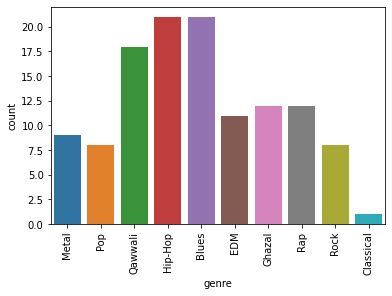

In [12]:
sns.countplot( x = results_wrong['genre'])
plt.xticks(rotation = 90)
plt.show()

In [13]:
results_wrong[results_wrong['genre'] == 'Qawwali']['preds'].value_counts(normalize=True)

Pop       0.444444
Rock      0.333333
Rap       0.111111
Ghazal    0.055556
Blues     0.055556
Name: preds, dtype: float64

In [14]:
results_wrong[results_wrong['genre'] == 'Blues']['preds'].value_counts(normalize=True)

Pop        0.761905
Hip-Hop    0.095238
Ghazal     0.047619
Qawwali    0.047619
Rap        0.047619
Name: preds, dtype: float64

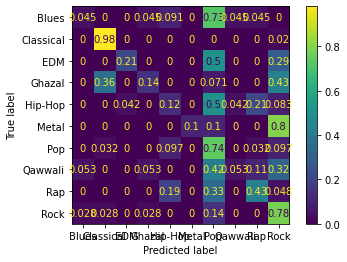

In [18]:
cmp = ConfusionMatrixDisplay.from_predictions(y_test, y_predicted, normalize = 'true')

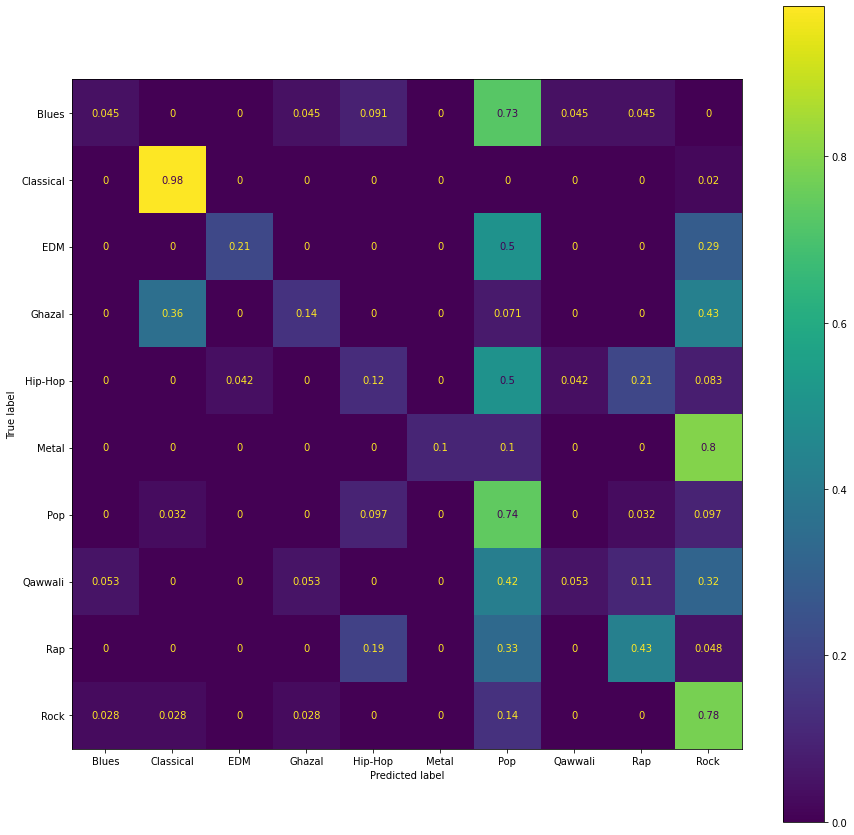

In [19]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.grid(False)
cmp.plot(ax = ax)

Unsurprisingly, Qawwali and Ghazal are the two most worst predicted genres based on this algorithm. This means, that there is a lot of room for improvement for future models